In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [3]:
from functions_v2 import(import_folder_dataset,
                         Data,
                         calculate_IoU,
                         plot_loss_accuracy, 
                         save_model,
                         save_metrics,
                         make_predictions)

# 1. Build an image segmentation model using pytorch

In [4]:
# Learning parameters.
epochs = 50 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

checkpoints_save = 25 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
        #################################
        ############ Encoder ############
        #################################
        
        '''
        In dimension:              1024 * 1024 * 3 
        Out dimension Conv:        1024 * 1024 * 64
        Out dimension MaxPooling:  512  * 512  * 64
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              512  * 512  * 64
        Out dimension Conv:        512  * 512  * 128
        Out dimension MaxPooling:  256  * 256  * 128
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              256  * 256  * 128
        Out dimension Conv:        256  * 256  * 256
        Out dimension MaxPooling:  128  * 128  * 256
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        #################################
        ############ Decoder ############
        #################################
        
        '''
        In dimension:                 128 * 128 * 256
        Out dimension Conv:           128 * 128 * 128
        Out dimension ConvTranspose:  256 * 256 * 128
        '''
        self.tcnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.convTrans3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        
        '''
        In dimension:                 256 * 256 * 128
        Out dimension Conv:           256 * 256 * 64
        Out dimension ConvTranspose:  512 * 512 * 64
        '''
        self.tcnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.convTrans4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        
        '''
        In dimension:                 512  * 512  * 64
        Out dimension Conv:           512  * 512  * 32
        Out dimension ConvTranspose:  1024 * 1024 * 32
        '''
        self.tcnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convTrans5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        '''
        In dimension:                 1024 * 1024 * 32
        Out dimension Conv:           1024 * 1024 * 2
        '''
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.ReLU()
        )
        
    def forward(self, x): 
        
        #################################
        ############ Encoder ############
        #################################
        #print("Before Cnn1 ",x.shape)
        # Convolution
        x = self.cnn1_model(x)
        #print("Before MaxPool1 ",x.shape)
        # Max pooling
        x = self.maxpool1(x)
        
        #print("Before Cnn2 ",x.shape)
        # Convolution
        x = self.cnn2_model(x)
        #print("Before MaxPool2 ",x.shape)
        # Max pooling
        x = self.maxpool2(x)
        
        #print("Before Cnn3 ",x.shape)
        # Convolution
        x = self.cnn3_model(x)
        #print("Before MaxPool3 ",x.shape)
        # Max pooling
        x = self.maxpool3(x)
        
        #################################
        ############ Decoder ############
        #################################
        
        #print("Before TCnn3 ",x.shape)
        # Convolution
        x = self.tcnn3_model(x)
        #print("Before ConvTransl3 ",x.shape)
        # Transopose Convolution
        x = self.convTrans3(x)
        
        #print("Before TCnn4 ",x.shape)
        # Convolution
        x = self.tcnn4_model(x)
        #print("Before ConvTransl4 ",x.shape)
        # Transopose Convolution
        x = self.convTrans4(x)
        
        #print("Before TCnn5 ",x.shape)
        # Convolution
        x = self.tcnn5_model(x)
        #print("Before ConvTransl5 ",x.shape)
        # Transopose Convolution
        x = self.convTrans5(x)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        #print("Before Segmentation ",x.shape)
        # Convolution Segmentation
        x = self.segmentation(x)
        #print("After Segmentation ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = SegmentationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")

# Loss function.
#criterion = nn.BCEWithLogitsLoss() # Set the loss function to BCEWithLogitsLoss
criterion = nn.CrossEntropyLoss()


parameters = filter(lambda p: p.requires_grad, modelpy.parameters())
optim = torch.optim.Adam(parameters, lr=lr)
#optim = torch.optim.SGD(params=parameters, lr=lr, momentum=0.9, weight_decay=1e-5)# , momentum=0.9, weight_decay=0.0005


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0

modelpy

model created


SegmentationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): S

In [7]:
# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion  = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")



In [8]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 1923214


## Load data

In [9]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Test"

img_size = (256, 256) # (1024, 1024)

In [10]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    #transforms.Resize((1024, 1024)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
train_data, train_mask, train_labels = import_folder_dataset(root_path = train_data_path, resized_side = img_size)#(1024,1024)

print("Dim of Data: ", train_data.shape)
print("Dim of Mask: ", train_mask.shape)
print("Dim of Lables: ", train_labels.shape)

100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Dim of Data:  (800, 256, 256, 3)
Dim of Mask:  (800, 256, 256, 3)
Dim of Lables:  (800, 256, 256)


In [12]:
# Split into Train, Validation
X_train, X_val, m_train, m_val, y_train, y_val = train_test_split(train_data, train_mask, train_labels, test_size=0.1, random_state=42)
print("Dim of Image Train: ", X_train.shape)
print("Dim of Mask Train: ", m_train.shape)
print("Dim of Lables Train: ", y_train.shape)


print("Dim of Image Validation: ", X_val.shape)
print("Dim of Mask Validation: ", m_val.shape)
print("Dim of Lables Validation: ", y_val.shape)

Dim of Image Train:  (720, 256, 256, 3)
Dim of Mask Train:  (720, 256, 256, 3)
Dim of Lables Train:  (720, 256, 256)
Dim of Image Validation:  (80, 256, 256, 3)
Dim of Mask Validation:  (80, 256, 256, 3)
Dim of Lables Validation:  (80, 256, 256)


In [13]:
# Create the dataset object
train_Dataset = Data(X_train, m_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, m_val, y_val, img_transform)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  720
Val len:  80


In [14]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)


Epoch 1 of 50


100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


train loss:  0.10600193788607916
Val loss:  0.11556276269257068
train IoU:  0.41017678928231666
Val IoU:  0.2773137092590332
Current time: 1.059 minutes. Time expected till completion: 51.891 minutes

Epoch 2 of 50


100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


train loss:  0.06251979242596362
Val loss:  0.0927323628216982
train IoU:  0.7003283427821265
Val IoU:  0.4732756197452545
Current time: 1.992 minutes. Time expected till completion: 47.809 minutes

Epoch 3 of 50


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


train loss:  0.0507484851198064
Val loss:  0.04592419303953647
train IoU:  0.7454991009500291
Val IoU:  0.770819503068924
Current time: 2.925 minutes. Time expected till completion: 45.826 minutes

Epoch 4 of 50


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


train loss:  0.04401095522981551
Val loss:  0.037714341282844545
train IoU:  0.7772478659947714
Val IoU:  0.8079415619373321
Current time: 3.856 minutes. Time expected till completion: 44.345 minutes

Epoch 5 of 50


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


train loss:  0.03726104573450155
Val loss:  0.039471558574587104
train IoU:  0.8101573361290826
Val IoU:  0.8224029809236526
Current time: 4.787 minutes. Time expected till completion: 43.085 minutes

Epoch 6 of 50


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


train loss:  0.03246931527844733
Val loss:  0.035683260578662154
train IoU:  0.8305044988791148
Val IoU:  0.8142727464437485
Current time: 5.718 minutes. Time expected till completion: 41.932 minutes

Epoch 7 of 50


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


train loss:  0.03036289895988173
Val loss:  0.03907301425933838
train IoU:  0.8424096518092685
Val IoU:  0.8057111203670502
Current time: 6.649 minutes. Time expected till completion: 40.842 minutes

Epoch 8 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.026478816035928
Val loss:  0.03054086989723146
train IoU:  0.8624571757184134
Val IoU:  0.8355567455291748
Current time: 7.579 minutes. Time expected till completion: 39.790 minutes

Epoch 9 of 50


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


train loss:  0.024454100559362108
Val loss:  0.0251281198579818
train IoU:  0.871546036336157
Val IoU:  0.8694751352071762
Current time: 8.519 minutes. Time expected till completion: 38.811 minutes

Epoch 10 of 50


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


train loss:  0.023240471688202684
Val loss:  0.025210494361817836
train IoU:  0.8761353880167008
Val IoU:  0.8694529384374619
Current time: 9.461 minutes. Time expected till completion: 37.842 minutes

Epoch 11 of 50


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


train loss:  0.022938727411544985
Val loss:  0.025093128718435765
train IoU:  0.8776975161499447
Val IoU:  0.8729854673147202
Current time: 10.410 minutes. Time expected till completion: 36.907 minutes

Epoch 12 of 50


100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


train loss:  0.02182528633210394
Val loss:  0.02631530137732625
train IoU:  0.8834310875998603
Val IoU:  0.8682744443416596
Current time: 11.357 minutes. Time expected till completion: 35.962 minutes

Epoch 13 of 50


100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


train loss:  0.02122895703651011
Val loss:  0.02373059866949916
train IoU:  0.8856448206636641
Val IoU:  0.8775626063346863
Current time: 12.302 minutes. Time expected till completion: 35.014 minutes

Epoch 14 of 50


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


train loss:  0.020695924976219734
Val loss:  0.024976500449702142
train IoU:  0.8873295482661989
Val IoU:  0.8599713027477265
Current time: 13.249 minutes. Time expected till completion: 34.070 minutes

Epoch 15 of 50


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


train loss:  0.019846774477304683
Val loss:  0.028351058484986424
train IoU:  0.8918143729368846
Val IoU:  0.8555578202009201
Current time: 14.205 minutes. Time expected till completion: 33.145 minutes

Epoch 16 of 50


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


train loss:  0.019890867163323694
Val loss:  0.02397214383818209
train IoU:  0.8898955666356616
Val IoU:  0.8651904821395874
Current time: 15.159 minutes. Time expected till completion: 32.212 minutes

Epoch 17 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.019894204086934528
Val loss:  0.022391582280397414
train IoU:  0.890892540746265
Val IoU:  0.8799115926027298
Current time: 16.113 minutes. Time expected till completion: 31.278 minutes

Epoch 18 of 50


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


train loss:  0.018878377265193397
Val loss:  0.0218555448576808
train IoU:  0.8955982787741555
Val IoU:  0.8773471742868424
Current time: 17.066 minutes. Time expected till completion: 30.340 minutes

Epoch 19 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.018919297297381694
Val loss:  0.022357598785310982
train IoU:  0.8956635740068224
Val IoU:  0.8823218166828155
Current time: 18.021 minutes. Time expected till completion: 29.402 minutes

Epoch 20 of 50


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


train loss:  0.018512581806215976
Val loss:  0.03492922438308597
train IoU:  0.8978522280852
Val IoU:  0.8221241593360901
Current time: 18.977 minutes. Time expected till completion: 28.465 minutes

Epoch 21 of 50


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


train loss:  0.017844144068658353
Val loss:  0.02518470771610737
train IoU:  0.900985938972897
Val IoU:  0.8772052586078644
Current time: 19.937 minutes. Time expected till completion: 27.532 minutes

Epoch 22 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.01778600880255302
Val loss:  0.024115839274600148
train IoU:  0.9003316187196307
Val IoU:  0.8812283635139465
Current time: 20.898 minutes. Time expected till completion: 26.597 minutes

Epoch 23 of 50


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


train loss:  0.01714968984015286
Val loss:  0.021741465106606482
train IoU:  0.903675475385454
Val IoU:  0.8861254900693893
Current time: 21.858 minutes. Time expected till completion: 25.660 minutes

Epoch 24 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.016648720370398627
Val loss:  0.025641002180054783
train IoU:  0.9066193997859955
Val IoU:  0.8643474757671357
Current time: 22.818 minutes. Time expected till completion: 24.720 minutes

Epoch 25 of 50


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


train loss:  0.016072862750540175
Val loss:  0.024906378146260975
train IoU:  0.9092096971140967
Val IoU:  0.8796440362930298
Saving model checkpoint


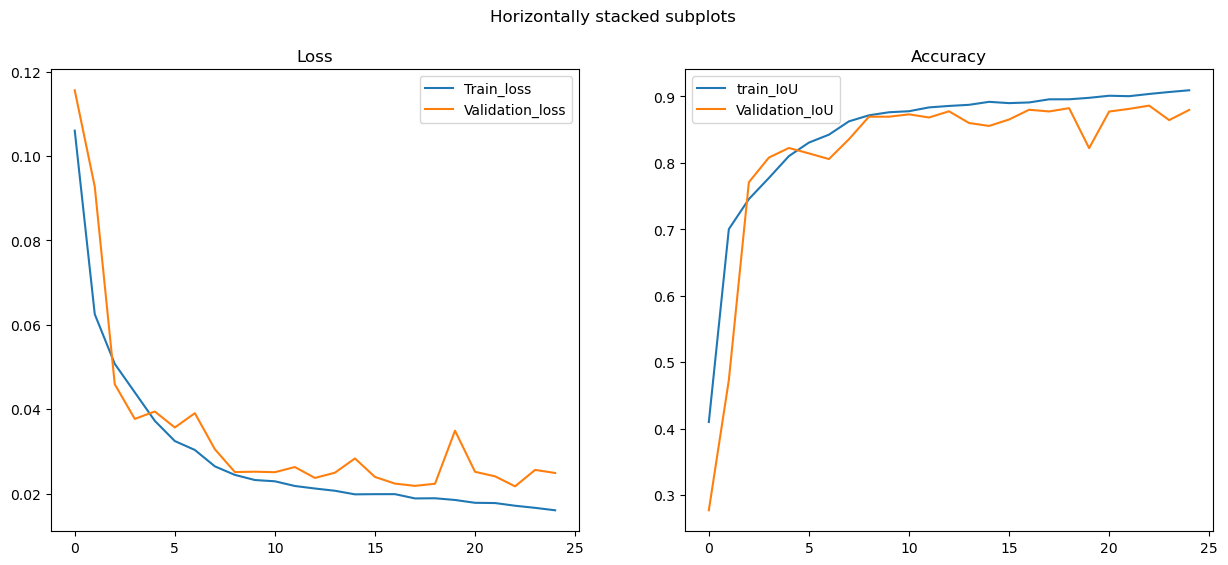

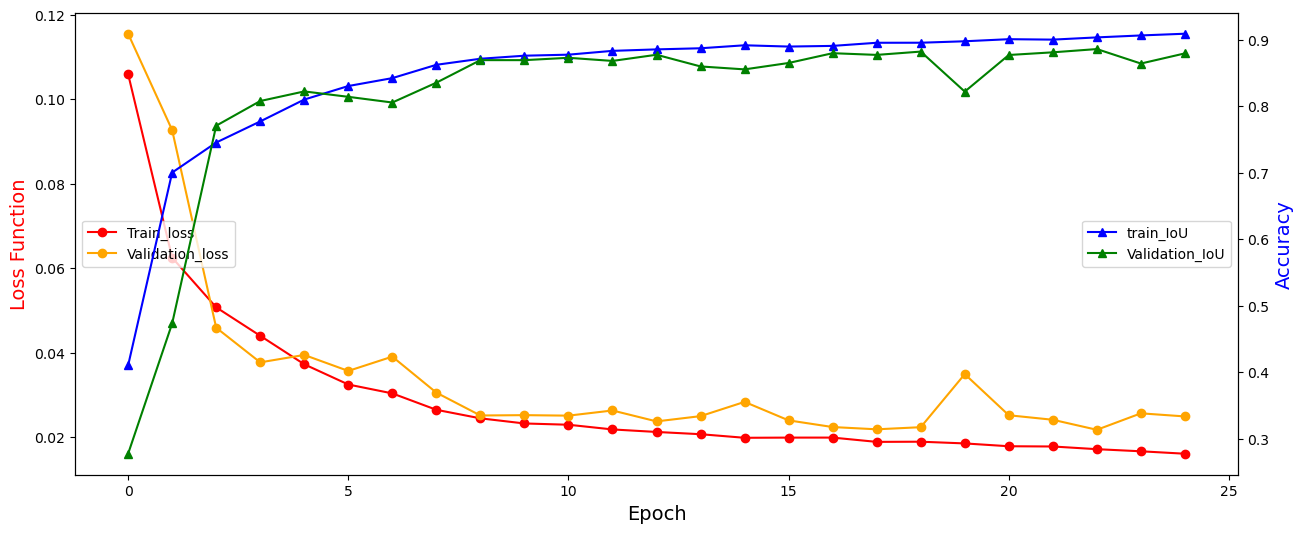

Current time: 23.805 minutes. Time expected till completion: 23.805 minutes

Epoch 26 of 50


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


train loss:  0.016002216671283046
Val loss:  0.02547039296478033
train IoU:  0.9100052932898204
Val IoU:  0.879341983795166
Current time: 24.755 minutes. Time expected till completion: 22.851 minutes

Epoch 27 of 50


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


train loss:  0.017007368461539347
Val loss:  0.022590499883517624
train IoU:  0.904054711262385
Val IoU:  0.8820460647344589
Current time: 25.709 minutes. Time expected till completion: 21.900 minutes

Epoch 28 of 50


100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


train loss:  0.015729793782035508
Val loss:  0.023994484078139068
train IoU:  0.9111556669076284
Val IoU:  0.8766130834817887
Current time: 26.664 minutes. Time expected till completion: 20.950 minutes

Epoch 29 of 50


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


train loss:  0.015606919065531757
Val loss:  0.02356041083112359
train IoU:  0.9117545869615343
Val IoU:  0.8843457877635956
Current time: 27.621 minutes. Time expected till completion: 20.001 minutes

Epoch 30 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.014988286720795763
Val loss:  0.023178822034969924
train IoU:  0.9146251678466797
Val IoU:  0.8832698702812195
Current time: 28.577 minutes. Time expected till completion: 19.052 minutes

Epoch 31 of 50


100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


train loss:  0.015514976572659281
Val loss:  0.024742861185222863
train IoU:  0.9122627973556519
Val IoU:  0.8801051944494247
Current time: 29.531 minutes. Time expected till completion: 18.100 minutes

Epoch 32 of 50


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


train loss:  0.015204024821933773
Val loss:  0.024221679847687482
train IoU:  0.913819569349289
Val IoU:  0.8814811408519745
Current time: 30.487 minutes. Time expected till completion: 17.149 minutes

Epoch 33 of 50


100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


train loss:  0.014410950652220183
Val loss:  0.022522304905578494
train IoU:  0.9178301894002491
Val IoU:  0.8862931817770004
Current time: 31.445 minutes. Time expected till completion: 16.199 minutes

Epoch 34 of 50


100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


train loss:  0.013459102602468596
Val loss:  0.02442901097238064
train IoU:  0.9228493657377032
Val IoU:  0.8814723819494248
Current time: 32.402 minutes. Time expected till completion: 15.248 minutes

Epoch 35 of 50


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


train loss:  0.013148136017844082
Val loss:  0.028860506089404225
train IoU:  0.924459954433971
Val IoU:  0.8786970883607864
Current time: 33.360 minutes. Time expected till completion: 14.297 minutes

Epoch 36 of 50


100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


train loss:  0.014252250527756081
Val loss:  0.02840878739953041
train IoU:  0.9187490224838257
Val IoU:  0.8650955110788345
Current time: 34.316 minutes. Time expected till completion: 13.345 minutes

Epoch 37 of 50


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


train loss:  0.013845956858454479
Val loss:  0.02443086989223957
train IoU:  0.9207115272680918
Val IoU:  0.8803839772939682
Current time: 35.271 minutes. Time expected till completion: 12.393 minutes

Epoch 38 of 50


100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


train loss:  0.012442539803062876
Val loss:  0.024526890181005002
train IoU:  0.928050449821684
Val IoU:  0.8852977573871612
Current time: 36.227 minutes. Time expected till completion: 11.440 minutes

Epoch 39 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.011966677160105771
Val loss:  0.02591448649764061
train IoU:  0.9307402948538462
Val IoU:  0.8839304864406585
Current time: 37.186 minutes. Time expected till completion: 10.488 minutes

Epoch 40 of 50


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


train loss:  0.011464728073527415
Val loss:  0.028627678146585823
train IoU:  0.9334575653076171
Val IoU:  0.8817993134260178
Current time: 38.146 minutes. Time expected till completion: 9.537 minutes

Epoch 41 of 50


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


train loss:  0.011648663795656627
Val loss:  0.0260200597345829
train IoU:  0.9324189537101322
Val IoU:  0.8844966351985931
Current time: 39.104 minutes. Time expected till completion: 8.584 minutes

Epoch 42 of 50


100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


train loss:  0.010863707659559118
Val loss:  0.028225242160260677
train IoU:  0.9369050330585904
Val IoU:  0.8799340575933456
Current time: 40.066 minutes. Time expected till completion: 7.632 minutes

Epoch 43 of 50


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


train loss:  0.010523198131057952
Val loss:  0.031002448964864017
train IoU:  0.9390856875313653
Val IoU:  0.8752366453409195
Current time: 41.028 minutes. Time expected till completion: 6.679 minutes

Epoch 44 of 50


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


train loss:  0.012290772687022885
Val loss:  0.027767625264823438
train IoU:  0.9298200928502612
Val IoU:  0.8778625875711441
Current time: 41.987 minutes. Time expected till completion: 5.725 minutes

Epoch 45 of 50


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


train loss:  0.009954120883614652
Val loss:  0.02967768986709416
train IoU:  0.9421918402115504
Val IoU:  0.878288397192955
Current time: 42.949 minutes. Time expected till completion: 4.772 minutes

Epoch 46 of 50


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


train loss:  0.009720699747817384
Val loss:  0.029882699111476542
train IoU:  0.9435835225714577
Val IoU:  0.8770878553390503
Current time: 43.910 minutes. Time expected till completion: 3.818 minutes

Epoch 47 of 50


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


train loss:  0.009416812929945688
Val loss:  0.02765012551099062
train IoU:  0.9449047419759963
Val IoU:  0.8812868565320968
Current time: 44.869 minutes. Time expected till completion: 2.864 minutes

Epoch 48 of 50


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


train loss:  0.008952308422885835
Val loss:  0.03388488385826349
train IoU:  0.9476997892061869
Val IoU:  0.8723408132791519
Current time: 45.808 minutes. Time expected till completion: 1.909 minutes

Epoch 49 of 50


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


train loss:  0.008361335310878026
Val loss:  0.03409515297971666
train IoU:  0.9511729243728849
Val IoU:  0.8700556367635727
Current time: 46.740 minutes. Time expected till completion: 0.954 minutes

Epoch 50 of 50


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


train loss:  0.008763207415015333
Val loss:  0.030353104835376142
train IoU:  0.9490069011847179
Val IoU:  0.8777655184268951
Saving model checkpoint


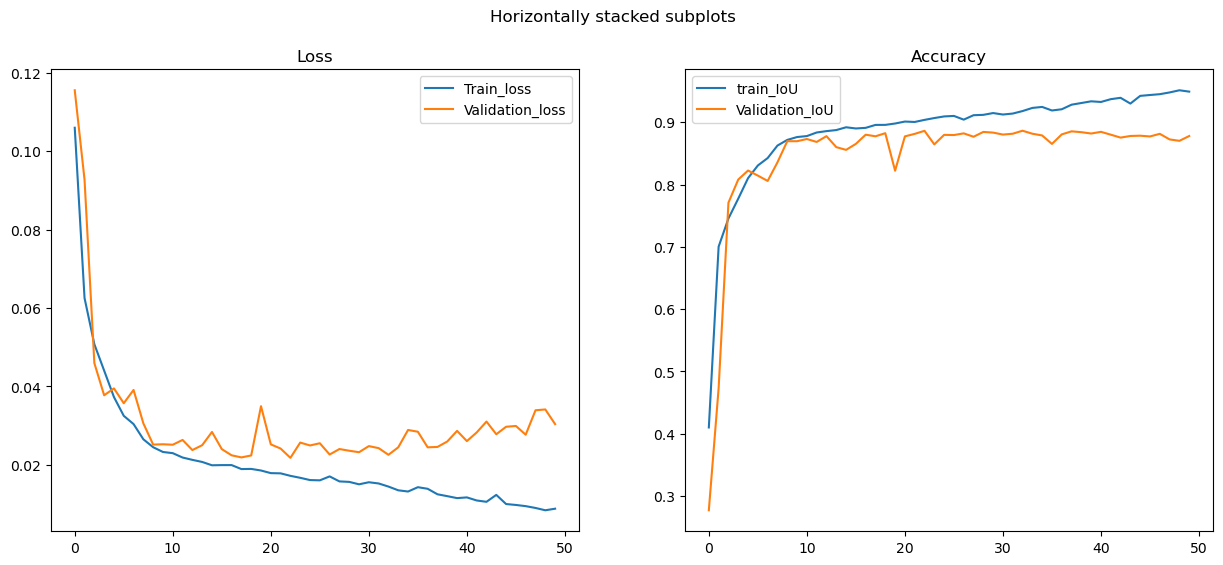

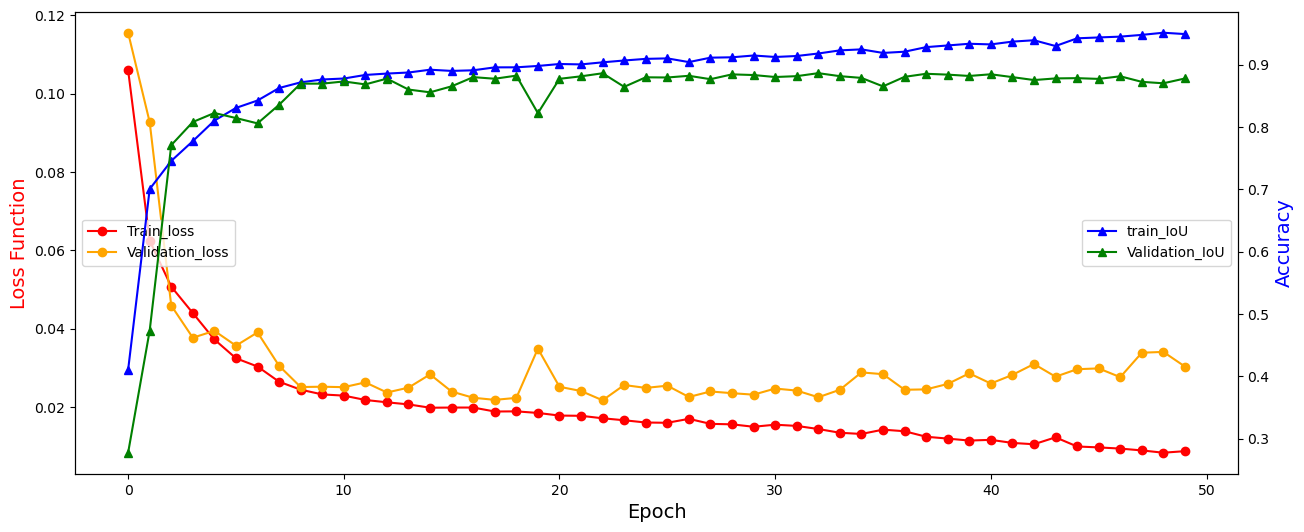

Current time: 47.691 minutes. Time expected till completion: 0.000 minutes
Finished training in: 47.691 minutes


In [15]:

# Main
train_loss, val_loss = [], []
train_IoU, val_IoU = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_IoU = dd["train_IoU"].tolist()
        val_IoU = dd["val_IoU"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    accumulatedIoU=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[2].to(device)# use the gpu
        
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate IoU
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        
        iioouu = calculate_IoU(predictions, labels)
        accumulatedIoU += iioouu.sum().item()
    
    train_epoch_loss = running_loss/len(train_loader.dataset)
    train_epoch_IoU = accumulatedIoU/total
    
    
    modelpy.eval()
    running_loss = 0.0
    total=0
    accumulatedIoU=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            labels = data[2].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, labels)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iioouu = calculate_IoU(predictions, labels)
            accumulatedIoU += iioouu.sum().item()
           
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_IoU = accumulatedIoU/total

    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train IoU: ", train_epoch_IoU)
    print("Val IoU: ", val_epoch_IoU)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_IoU.append(train_epoch_IoU)
    val_IoU.append(val_epoch_IoU)
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_IoU, val_IoU, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

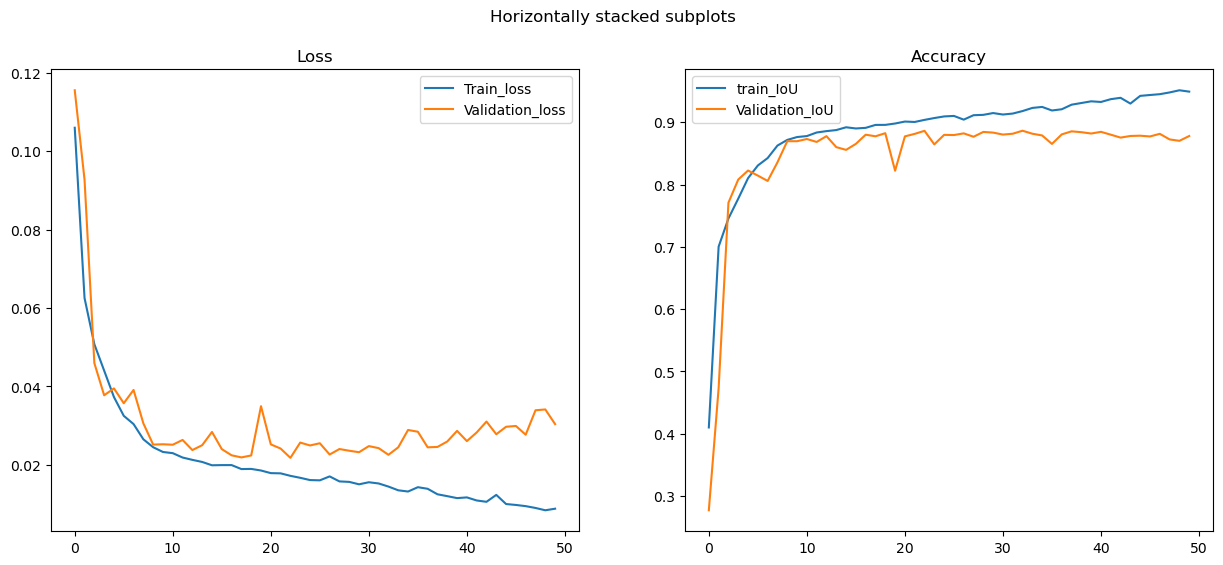

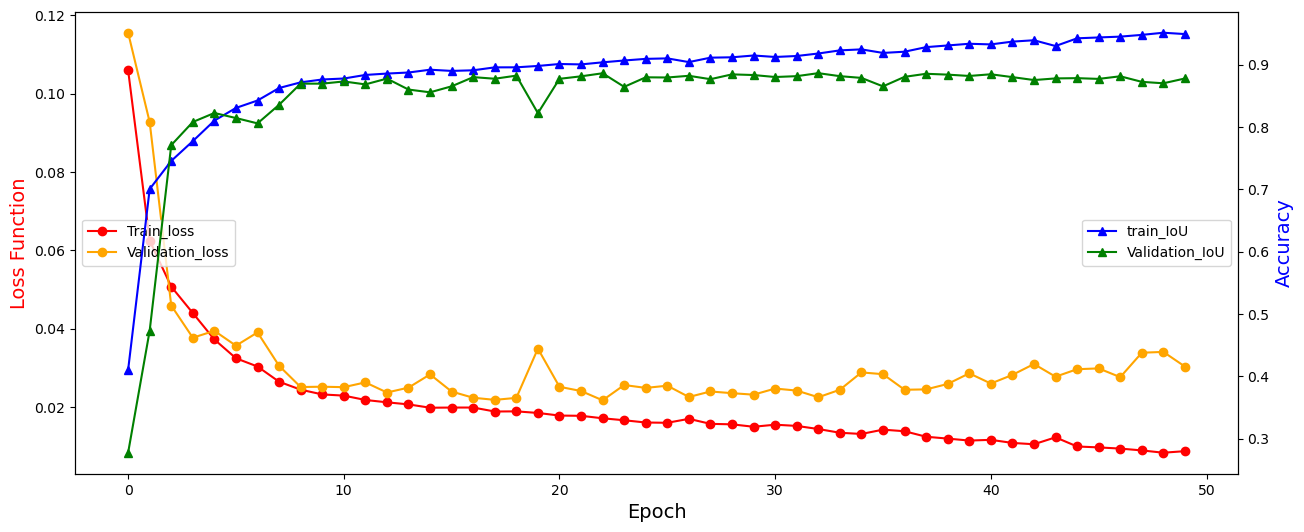

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)

## Save Model

In [17]:
# Save Model
NAME = "model_1.pt"

torch.save(modelpy.state_dict(), model_checkpoints+NAME)

## Load Model

In [18]:

# Load the model
NAME = "model_1.pt"
modelpy.load_state_dict(torch.load(model_checkpoints+NAME, map_location=device))


<All keys matched successfully>

# 3.Evaluate your model using the test images

In [19]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [20]:
test_data, test_mask, test_labels = import_folder_dataset(root_path = test_data_path, resized_side = img_size)#(1024,1024)


print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)

100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)


In [21]:
# Create the dataset object
test_Dataset = Data(test_data, test_mask, test_labels, img_transform) 


print("Test len: ",len(test_Dataset))

Test len:  200


In [22]:
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,
    shuffle=False
    )

In [23]:

mean_IoU, mean_dice, image_list, mask_list, predictions_list = make_predictions(loader = test_loader, 
                                                                     model = modelpy, 
                                                                     invTransforamtion = invTrans,
                                                                     device = device)
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

100%|██████████| 200/200 [00:07<00:00, 28.47it/s]

Average IoU of the model on the 200 Test dataset instances: 89.23065736889839%
Average Dice of the model on the 200 Test dataset instances: 94.23150280117989%


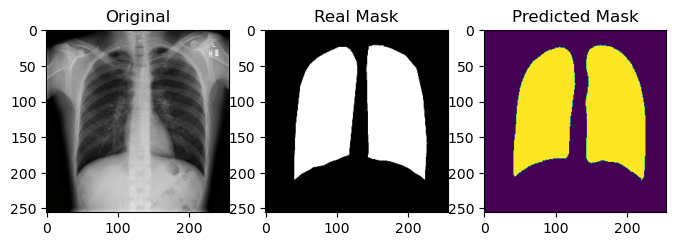

In [24]:
image_to_plot = 10

real_image = image_list[image_to_plot]
real_mask = mask_list[image_to_plot]
pred_mask = predictions_list[image_to_plot]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(8,8))
ax1.imshow(real_image)
ax1.title.set_text("Original")
ax2.imshow(real_mask)
ax2.title.set_text("Real Mask")
ax3.imshow(pred_mask)
ax3.title.set_text("Predicted Mask")
plt.show()

# 4. Your IoU score should be higher than 0.82

In [25]:
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')

Average IoU of the model on the 200 Test dataset instances: 89.23065736889839%


In [26]:
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

Average Dice of the model on the 200 Test dataset instances: 94.23150280117989%


# 5. Write a two-page report using LaTex and upload your paper to ResearchGate or Arxiv. 
